# Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 

You can download the dataset from [here](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/big-mart-sales-prediction/test_AbJTz2l.csv
/kaggle/input/big-mart-sales-prediction/train_v9rqX0R.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

# Importing the Dataset and Understanding the features

In [4]:
train_df = pd.read_csv('/kaggle/input/big-mart-sales-prediction/train_v9rqX0R.csv')
test_df = pd.read_csv('/kaggle/input/big-mart-sales-prediction/test_AbJTz2l.csv')

In [5]:
train_df.shape, test_df.shape

((8523, 12), (5681, 11))

In [6]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Item_Identifier**    -> Unique product ID

**Item_Weight**        -> Weight of product

**Item_Fat_Content**   -> Whether the product is low fat or not

**Item_Visibility**    -> The % of total display area of all products in a store allocated to the particular product

**Item_Type**          -> The category to which the product belongs

**Item_MRP**           -> Maximum Retail Price (list price) of the product

**Outlet_Identifier**  -> Unique store ID

**Outlet_Establishment_Year** -> The year in which store was established

**Outlet_Size**        -> The size of the store in terms of ground area covered

**Outlet_Location_Type** -> The type of city in which the store is located

**Outlet_Type**        -> Whether the outlet is just a grocery store or some sort of supermarket

**Item_Outlet_Sales** (Target) -> Sales of the product in the particular store. This is the outcome variable to be predicted.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Understanding Categorical Variables

In [9]:
train_df.Item_Identifier.value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Since the number of categories is quite large, OneHotEncoding this categorical Variable will lead to very high memory consumption and increase in training time. Hence I will not use this column while training the model. 

In [10]:
train_df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

LF - Low Fat
low fat - Low Fat
reg - Regular
These things must be handled

In [11]:
train_df.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [12]:
train_df.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [13]:
train_df.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [14]:
train_df.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [15]:
train_df.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

# Filling in Missing Values

In [16]:
train_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [17]:
test_df.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

Since Item_Weight and Outlet_Size are having Null values, they have to be imputed and Outlet establishment year do not have any significance if we are calcuating the sales. But, if I get the age of the outlet, then it might be useful.

In [18]:
outlet_table = train_df.groupby(by=['Outlet_Identifier','Outlet_Size']).count().reset_index()[['Outlet_Identifier','Outlet_Size']]
outlet_table

,Outlet_Identifier,Outlet_Size
0,OUT013,High
1,OUT018,Medium
2,OUT019,Small
3,OUT027,Medium
4,OUT035,Small
5,OUT046,Small
6,OUT049,Medium


Seems like the data is available for only 7 of the 10 shops. That might be the reason why there are so many missing values in Outlet_Size. Let me try to analyze the Outlet Type and Outlet Size.

In [19]:
outlet_table = train_df.groupby(by=['Outlet_Type','Outlet_Size']).count().reset_index()[['Outlet_Type','Outlet_Size']]
outlet_table

,Outlet_Type,Outlet_Size
0,Grocery Store,Small
1,Supermarket Type1,High
2,Supermarket Type1,Medium
3,Supermarket Type1,Small
4,Supermarket Type2,Medium
5,Supermarket Type3,Medium


SuperMarket type2 and type 3 are mostly Medium size and Grocery Store is Small Size. But if the type is super market type 1, I there are all 3 possibilities. I will impute the most frequent values just in case if the type3 store occurs.

In [20]:
item_table = train_df.groupby(by=['Item_Identifier','Item_Weight']).count().reset_index()[['Item_Identifier','Item_Weight']].groupby('Item_Identifier').mean().reset_index()
item_table

,Item_Identifier,Item_Weight
0,DRA12,11.600
1,DRA24,19.350
2,DRA59,8.270
3,DRB01,7.390
4,DRB13,6.115
...,...,...
1550,NCZ30,6.590
1551,NCZ41,19.850
1552,NCZ42,10.500
1553,NCZ53,9.600


I have created two tables outlet_table and item_table which consists of the outlets types and their respective sizes and item and their mean weights. I will impute these values in the the train_df and if there are even more nan values, I will impute by using the mean.

In [21]:
def fillna(dataframe):
    
    #Imputing Values based on outlet_table and item_table
    dataframe['Item_Weight'] = dataframe[['Item_Identifier','Item_Weight']].groupby(by=['Item_Identifier']).transform(lambda x: x.fillna(x.mean()))['Item_Weight']
    dataframe['Outlet_Size'] = dataframe[['Outlet_Type','Outlet_Size']].groupby(by='Outlet_Type').transform(lambda x: x.fillna(x.mode()[0]))['Outlet_Size']
    
    
    #Imputing values if there are any more nan values present
    dataframe.Item_Weight.fillna(dataframe.Item_Weight.mean(), inplace=True)
    dataframe.Outlet_Size.fillna(dataframe.Outlet_Size.mode()[0], inplace=True)
    
    dataframe.Item_Fat_Content.replace({"low fat":"Low Fat","LF":"Low Fat","reg":"Regular"}, inplace=True)
    dataframe['Outlet_Age'] = 2022 - pd.to_numeric(dataframe['Outlet_Establishment_Year'])
    
    return dataframe

In [22]:
fillna(train_df).Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Now, the Item_Fat_Content column is corrected.

In [23]:
fillna(train_df).isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Outlet_Age                   0
dtype: int64

# Exploratory Data Analysis

In [24]:
eda_df = fillna(train_df).copy()
eda_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age'],
      dtype='object')

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Count'>

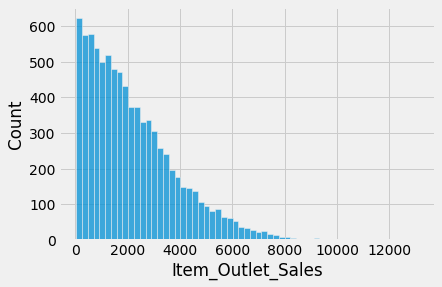

In [25]:
sns.histplot(data=eda_df, x='Item_Outlet_Sales')

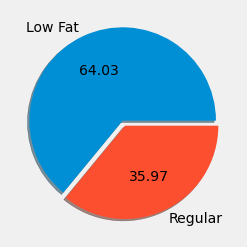

In [26]:
pie=eda_df.groupby(by='Item_Fat_Content').sum()
plt.pie(labels=pie.index, x=pie['Item_Outlet_Sales'], explode=[0.03]*len(pie.index) , autopct="%.2f", shadow=True);

Low Fat products seems to have performed well when compared to the Regular counterparts. This pie chart tells that the people tend to prefer Low Fat products rather than regular ones.

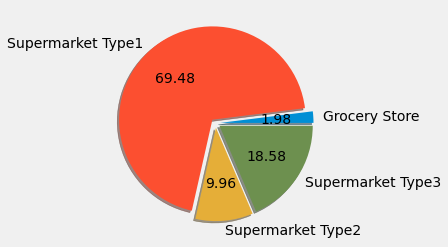

In [27]:
pie=eda_df.groupby(by='Outlet_Type').sum()
plt.pie(labels=pie.index, x=pie['Item_Outlet_Sales'], explode=[0.05]*len(pie.index), autopct="%.2f",shadow=True);

Seems like most of the sales is generated by SuperMarket Type 1 stores and least sales are generated by the Grocery Stores.

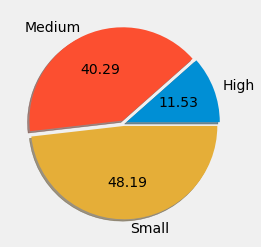

In [28]:
pie=eda_df.groupby(by='Outlet_Size').sum()
plt.pie(labels=pie.index, x=pie['Item_Outlet_Sales'], explode=[0.03]*len(pie.index), autopct="%.2f",shadow=True);

Most sales is generated by Small stores followed by the medium stores. If we look at the above pie chart, the previous pie chart and the table that I created (outlet_table), it is clear that there are only 2 types of stores that are categorized as small. Grocery Store and SuperMarket Type1. This means we can infer that most of the sales of Small type shops are from Supermarket type1 stores.

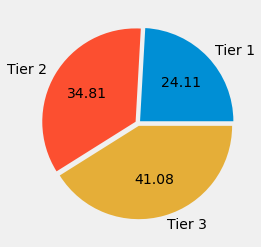

In [29]:
pie=eda_df.groupby(by='Outlet_Location_Type').sum()
plt.pie(labels=pie.index, x=pie['Item_Outlet_Sales'], explode=[0.03]*len(pie.index), autopct="%.2f");

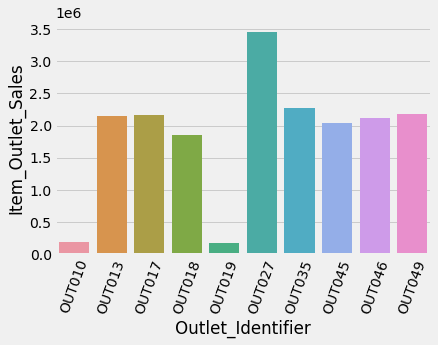

In [30]:
bar=eda_df.groupby(by='Outlet_Identifier').sum()
sns.barplot(data=bar,x=bar.index,y='Item_Outlet_Sales');
plt.xticks(rotation=70);

Outlet OUT027 has achieved the highest sales whereas OUT019 and OUT10 have achieved the lowest sales.

Let me check the age of these stores so as to find out whether these are newer stores or older ones and check their location.

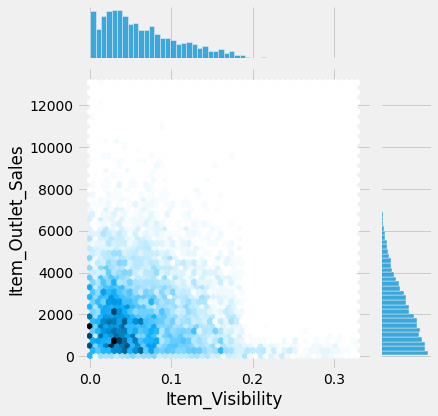

In [31]:
sns.jointplot(data=eda_df, x='Item_Visibility',y='Item_Outlet_Sales',kind='hex');

It is evident from the above plot that a some of products which had more visibility was not sold that much when compared with a number of products that did not have any visibility. 

This shows that increase in visibility do not guarantee sale.

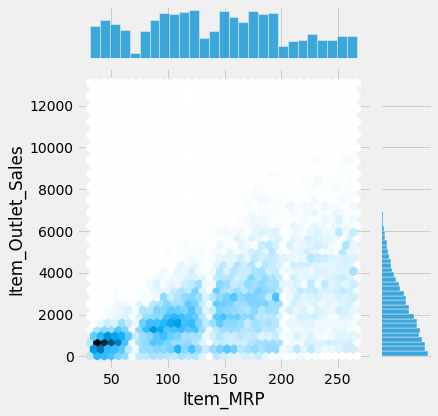

In [32]:
sns.jointplot(data=eda_df, x='Item_MRP',y='Item_Outlet_Sales', kind='hex');

The above plot shows that the items with least MRP are sold the most but the total sale value is much lesser when compared to the items that habe more MRP.

### Conclusions From EDA

* people tend to prefer Low Fat products rather than regular ones
* most of the sales is generated by SuperMarket Type 1 stores
* Most sales is generated by Small stores followed by the medium stores
* Outlet OUT027 has achieved the highest sales
* some of products which had more visibility was not sold that much when compared with a number of products that did not have any visibility

### Check for multicollinearity

In [33]:
numeric_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']

vif = pd.DataFrame()
vif["variables"] = numeric_cols
vif["VIF"] = [variance_inflation_factor(train_df[numeric_cols].values, i) for i in range(len(numeric_cols))]
vif

,variables,VIF
0,Item_Weight,5.952439
1,Item_Visibility,2.518026
2,Item_MRP,4.823793
3,Outlet_Age,6.238621


# Encoding Categorical Variables

In [34]:
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age'],
      dtype='object')

In [35]:
numeric_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
categoric_col = ['Item_Type','Outlet_Size','Outlet_Location_Type', 'Item_Fat_Content','Outlet_Type', 'Outlet_Identifier']
scaler = MinMaxScaler()
def encode(dataframe):
    dataframe = fillna(dataframe)
    encoded = pd.get_dummies(dataframe[categoric_col]).columns
    dataframe[encoded] = pd.get_dummies(dataframe[categoric_col])
    dataframe[numeric_cols] = scaler.fit_transform(dataframe[numeric_cols])
    return dataframe

In [36]:
encode(train_df).head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,0.282525,Low Fat,0.048866,Dairy,0.927507,OUT049,1999,Medium,Tier 1,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,0.081274,Regular,0.058705,Soft Drinks,0.072068,OUT018,2009,Medium,Tier 3,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,0.770765,Low Fat,0.051037,Meat,0.468288,OUT049,1999,Medium,Tier 1,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,0.871986,Regular,0.000000,Fruits and Vegetables,0.640093,OUT010,1998,Small,Tier 3,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,0.260494,Low Fat,0.000000,Household,0.095805,OUT013,1987,High,Tier 3,...,0,1,0,0,0,0,0,0,0,0


# Splitting the Dataset into train set and test set

In [37]:
train_df = encode(train_df)
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,0.282525,Low Fat,0.048866,Dairy,0.927507,OUT049,1999,Medium,Tier 1,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,0.081274,Regular,0.058705,Soft Drinks,0.072068,OUT018,2009,Medium,Tier 3,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,0.770765,Low Fat,0.051037,Meat,0.468288,OUT049,1999,Medium,Tier 1,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,0.871986,Regular,0.000000,Fruits and Vegetables,0.640093,OUT010,1998,Small,Tier 3,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,0.260494,Low Fat,0.000000,Household,0.095805,OUT013,1987,High,Tier 3,...,0,1,0,0,0,0,0,0,0,0


In [38]:
encoded_cols = pd.get_dummies(train_df[categoric_col]).columns
numeric_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
inputs = list(encoded_cols) + list(numeric_cols)
target = 'Item_Outlet_Sales'
inputs

['Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Size_High',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identi

In [39]:
train_x, test_x, train_y, test_y = train_test_split(train_df[inputs],train_df[target],random_state=42, shuffle = True, test_size = 0.2)

In [40]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6818, 42), (1705, 42), (6818,), (1705,))

# Building Machine Learning Models

### 1. Building a Linear Regression Model

In [41]:
lr = LinearRegression() #1226
lr.fit(train_x,np.log(train_y))
print(mean_squared_error(train_y, np.exp(lr.predict(train_x)), squared=False), 
      mean_squared_error(test_y, np.exp(lr.predict(test_x)), squared=False))

1150.801487168572 1084.0957748662668


### 2. Building a Decision Tree Model

In [42]:
dt = DecisionTreeRegressor(random_state=42, splitter='random')
dt.fit(train_x,train_y)
mean_squared_error(train_y, dt.predict(train_x), squared=False), mean_squared_error(test_y, dt.predict(test_x), squared=False)

(0.0, 1459.4683756891316)

#### Tuning Hyperparameters of Decision Tree Regressor

In [43]:
def test_params_dt(**params):
    model = DecisionTreeRegressor(random_state=42, splitter='random', **params).fit(train_x, train_y)
    train_rmse = mean_squared_error(model.predict(train_x), train_y, squared=False)
    val_rmse = mean_squared_error(model.predict(test_x), test_y, squared=False)
    return train_rmse, val_rmse

In [44]:
def test_param_and_plot_dt(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params_dt(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

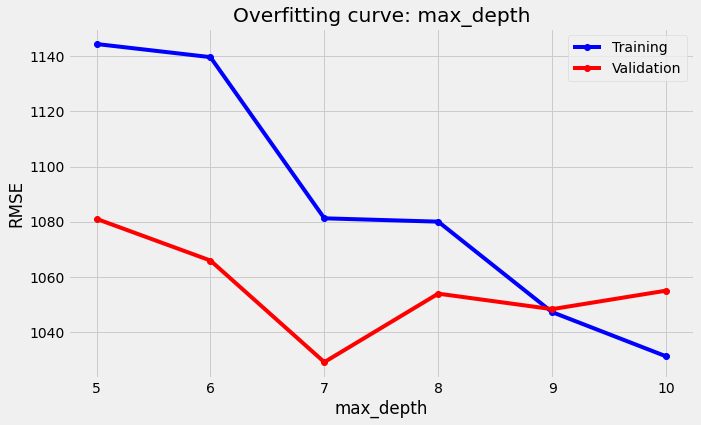

In [45]:
test_param_and_plot_dt('max_depth',[5,6,7,8,9,10])

In [46]:
test_params_dt(max_depth=9) #1162

(1047.3044200292584, 1048.3837758816223)

In [47]:
kfold = KFold(n_splits=5)

dt_models = []

for train_index, test_index in kfold.split(train_df[inputs],train_df[target]):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:][target], train_df.loc[test_index,:][target]
    
    model = DecisionTreeRegressor(max_depth=9,random_state=42, splitter='random')
    
    model.fit(X_train[inputs],y_train)
    
    dt_models.append(model)
    
    print("Train rmse:",mean_squared_error(y_train,model.predict(X_train[inputs]), squared=False),
                    "\nTest rmse:",mean_squared_error(y_test,model.predict(X_test[inputs]), squared=False),
                "\n-------------------------------------------------")

Train rmse: 1027.7302580490345 
Test rmse: 1156.0407126825182 
-------------------------------------------------
Train rmse: 1036.286690372661 
Test rmse: 1101.2622035495635 
-------------------------------------------------
Train rmse: 1044.0905975264047 
Test rmse: 1117.8689412836006 
-------------------------------------------------
Train rmse: 1039.279192079598 
Test rmse: 1107.2926255987918 
-------------------------------------------------
Train rmse: 1030.4351580479472 
Test rmse: 1116.0094698401251 
-------------------------------------------------


In [48]:
dt_final = dt_models[2]

### 3. Building RandomForest Regressor Model

In [49]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(train_x,train_y)
print(mean_squared_error(train_y, rf.predict(train_x), squared=False), 
                    mean_squared_error(test_y, rf.predict(test_x), squared=False))

430.40187919942747 1079.3073410523257


#### Tuning Hyperparameters of Random Forest Regressor

In [50]:
def test_params_rf(**params):
    model = RandomForestRegressor(n_jobs=-1, random_state=42, **params).fit(train_x, train_y)
    train_rmse = mean_squared_error(model.predict(train_x), train_y, squared=False)
    val_rmse = mean_squared_error(model.predict(test_x), test_y, squared=False)
    return train_rmse, val_rmse

In [51]:
def test_param_and_plot_rf(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params_rf(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

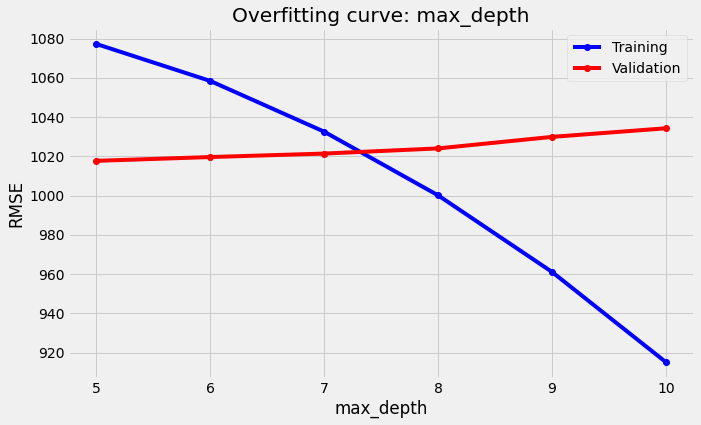

In [52]:
test_param_and_plot_rf('max_depth',[5,6,7,8,9,10])

In [53]:
test_params_rf(min_samples_split=100)  #1156

(1016.2408902997718, 1021.9409534716877)

In [54]:
kfold = KFold(n_splits=5,shuffle=True,random_state=42)

rf_models = []

for train_index, test_index in kfold.split(train_df[inputs],train_df[target]):
    X_train, X_test = train_df.loc[train_index,:], train_df.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,:][target], train_df.loc[test_index,:][target]
    
    model = RandomForestRegressor(min_samples_split=100,random_state=42, n_jobs=-1)
    
    model.fit(X_train[inputs],y_train)
    
    rf_models.append(model)
    
    print("Train rmse:",mean_squared_error(y_train,model.predict(X_train[inputs]), squared=False),
                    "\nTest rmse:",mean_squared_error(y_test,model.predict(X_test[inputs]), squared=False),
                "\n-------------------------------------------------")

Train rmse: 1015.3367697777462 
Test rmse: 1022.4421428263263 
-------------------------------------------------
Train rmse: 1001.5810564410103 
Test rmse: 1079.4908855870965 
-------------------------------------------------
Train rmse: 1003.2387630435567 
Test rmse: 1075.2167161912414 
-------------------------------------------------
Train rmse: 992.4008775542936 
Test rmse: 1116.2680875189046 
-------------------------------------------------
Train rmse: 992.790384889733 
Test rmse: 1117.7449139459 
-------------------------------------------------


In [55]:
final_rf = rf_models[0] #1150

### 4. Bulding Ada Boost Regressor

In [56]:
ada = AdaBoostRegressor(base_estimator=dt_final, random_state=42, learning_rate=0.04)
ada.fit(train_x,train_y)
print(mean_squared_error(train_y, ada.predict(train_x), squared=False), 
                    mean_squared_error(test_y, ada.predict(test_x), squared=False)) #1156

1030.3168341909989 1019.6524064942726


### 5. Advanced Ensembling Methods Stacking and Blending

In [57]:
vr = VotingRegressor(
                estimators = [('dt',DecisionTreeRegressor(splitter='random')),('rf',RandomForestRegressor())],
                n_jobs=-1)
vr.fit(train_x,train_y)
print(mean_squared_error(train_y, vr.predict(train_x), squared=False), 
                    mean_squared_error(test_y, vr.predict(test_x), squared=False)) #1156

213.49717336335476 1184.2379915666345


In [58]:
sr = StackingRegressor(
            estimators=[('dt',DecisionTreeRegressor(random_state=42, splitter='random')),
                         ('rf',RandomForestRegressor(random_state=42, n_jobs=-1))],
            final_estimator=LinearRegression())
sr.fit(train_x,train_y)
print(mean_squared_error(train_y, sr.predict(train_x), squared=False), 
                    mean_squared_error(test_y, sr.predict(test_x), squared=False)) 

488.12651416036965 1073.356525007981


# Predictions

In [59]:
test_df = encode(test_df)

In [60]:
preds = sr.predict(test_df[inputs])

In [61]:
output = pd.DataFrame({'Item_Identifier':test_df.Item_Identifier,'Outlet_Identifier':test_df.Outlet_Identifier, 'Item_Outlet_Sales':preds})

In [62]:
output.to_csv('submission.csv',index=False)

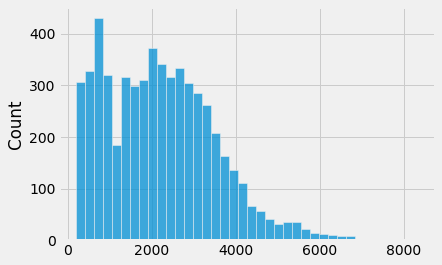

In [63]:
sns.histplot(preds);